# IMPORTA BIBLIOTECAS

In [54]:
import time
import json
import pandas as pd
import numpy as np
from datetime import datetime

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException


from webdriver_manager.chrome import ChromeDriverManager
from dotenv import load_dotenv
import os

In [2]:
# Carregar credenciais do arquivo .env
load_dotenv()
LINKEDIN_EMAIL = os.getenv("LINKEDIN_EMAIL")
LINKEDIN_PASSWORD = os.getenv("LINKEDIN_PASSWORD")

# CONFIGURAÇÃO DO AMBIENTE

In [3]:
# Configuração do Selenium
def setup_driver():
    options = Options()
    options.add_argument("--start-maximized")
    options.add_argument("--disable-notifications")
    service = Service(ChromeDriverManager().install())
    driver = webdriver.Chrome(service=service, options=options)
    return driver

In [4]:
# Autenticar no LinkedIn
def linkedin_login(driver):
    driver.get("https://www.linkedin.com/login")
    time.sleep(2)

    email_field = driver.find_element(By.ID, "username")
    password_field = driver.find_element(By.ID, "password")

    email_field.send_keys(LINKEDIN_EMAIL)
    password_field.send_keys(LINKEDIN_PASSWORD)
    password_field.send_keys("\ue007")  # Pressionar Enter
    time.sleep(3)


In [5]:
# Adicionar rolagem na página
def scroll_down(driver):
    driver.execute_script("window.scrollBy(0, 300);")
    time.sleep(0.5)  # Esperar um pouco para que novos elementos sejam carregados

# PROCESSO DO SCRAPING

In [6]:
# Extrair conexões
def extract_connections(driver, profile_url):
    driver.get(profile_url)
    time.sleep(3)

    extracted_data = {}

    try:
        # Clicar no link de conexões
        WebDriverWait(driver, 10).until(
            EC.element_to_be_clickable(
                (
                    By.CLASS_NAME,
                    "jBoWjCkDnQAudKFlfzuYKZdcceDKXE.inline-flex.align-items-center.link-without-hover-visited.pt2",
                )
            )
        ).click()
        time.sleep(2)

        # Inicializar a lista de nomes extraídos
        names = []

        while True:
            # Extração dos nomes na página atual
            name_elements = driver.find_elements(
                By.CLASS_NAME,
                "sVERDkcTlYPzPQlJOoKTEBiRQdqFMDVxijI.KSOPGGTUwpqguKseMcspzYpZImxdaDTs ",
            )
            # print([name.text.split('\n')[0] for name in name_elements if name.text])
            names.extend(
                [name.text.split("\n")[0] for name in name_elements if name.text]
            )

            # Tentar ir para a próxima página
            try:
                scroll_down(driver)
                next_button = driver.find_element(
                    By.XPATH, "//button[@aria-label='Avançar']"
                )
                if "disabled" in next_button.get_attribute("class"):
                    break  # Botão de próximo desabilitado, última página
                next_button.click()
                time.sleep(2)
            except NoSuchElementException:
                break  # Botão de próximo não encontrado, última página

        # Adicionar ao dicionário de dados extraídos
        extracted_data[profile_url] = names
        print(
            f"Conexões extraídas para {profile_url}: {len(names)} conexões encontradas."
        )

    except Exception as e:
        print(f"Erro ao acessar {profile_url}: {e}")

    return extracted_data

# CONSTRUÇÃO DO GRAFO

In [7]:
# Iterar pelas conexões e salvar resultados em JSON
def process_connections(file_path, output_path, driver):
    connections_df = pd.read_csv(file_path, sep=";")
    total = connections_df.shape[0]

    try:
        with open(output_path, "r", encoding="utf-8") as json_file:
            all_data = json.load(json_file)
    except (FileNotFoundError, json.JSONDecodeError):
        all_data = {}
    

    for index, row in connections_df.iterrows():
        profile_url = row["URL"]
        # Ignorar perfis já processados
        if profile_url in all_data:
            print(f"Perfil já processado: {row['First Name']} {row['Last Name']} => {profile_url}. Ignorando...")
            continue

        print(f"Processando {index + 1}/{total}: {row['First Name']} {row['Last Name']} => {profile_url} ==> {datetime.now()}")

        data = extract_connections(driver, profile_url)
        all_data.update(data)

        # Salvar os dados extraídos em um arquivo JSON
        with open(output_path, "w", encoding="utf-8") as json_file:
            json.dump(all_data, json_file, ensure_ascii=False, indent=4)

    print(f"Dados salvos em {output_path}")
    return all_data

# DEFINIÇÃO DO PIPELINE

In [8]:
# Pipeline principal
def run_pipeline(file_path, output_path):
    # Configurações de entrada e saída
    # file_path = "Connections.csv"  # Substitua pelo caminho correto
    # output_path = "extracted_connections.json"  # Nome do arquivo de saída

    print(f"Processo Iniciado ==> {datetime.now()}")
    print(50 * "==")

    # Configuração do Selenium
    driver = setup_driver()
    print(f"Driver Configurado ==> {datetime.now()}")
    print(50 * "==")

    # Login no LinkedIn
    linkedin_login(driver)
    print(f"Login Realizado ==> {datetime.now()}")
    print(50 * "==")

    # Processar conexões e salvar dados
    all_data = process_connections(file_path, output_path, driver)
    print(50 * "==")
    
    print(f"Finalizado Processamento ==> {datetime.now()}")
    # Fechar o navegador
    driver.quit()

    return all_data

# EXECUÇÃO DO PROCESSO

In [9]:
# Executar no Jupyter Notebook
file_path = (
    "..\small_world_linkedin\data\linkedin_urls.csv"  # Substitua pelo caminho correto
)
output_path = (
    "..\small_world_linkedin\data\linkedin_graph.json"  # Nome do arquivo de saída
)

In [ ]:
all_data = run_pipeline(file_path, output_path)

# TESTES DE UNIFICAÇÂO

In [51]:
import networkx as nx
from pyvis.network import Network
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from scipy.stats import powerlaw, kstest

## PROCESS DATA

In [83]:
def process_data(json_file, csv_file):
    # Carregar JSON
    with open(json_file, 'r', encoding='utf-8') as file:
        json_data = json.load(file)
    
    # Carregar CSV
    csv_data = pd.read_csv(csv_file, sep=';')
    csv_data['Connected On'] = pd.to_datetime(csv_data['Connected On'], dayfirst=True)
    csv_data['Days Connected'] = (datetime.now() - csv_data['Connected On']).dt.days
    
    # Criar um DataFrame para os relacionamentos do JSON
    relationships = []
    for url, names in json_data.items():
        for name in names:
            relationships.append({"URL": url, "Connection Name": name})
    
    json_df = pd.DataFrame(relationships)
    
    # Mesclar os dois DataFrames usando o campo "URL"
    combined_df = pd.merge(csv_data, json_df, on="URL", how="inner")
    
    return combined_df


## CREATE GRAPH

In [33]:
# Função para criar e exibir o grafo
def create_graph(dataframe):
    # Criar o grafo
    graph = nx.Graph()
    
    # Adicionar nós e arestas no grafo
    for _, row in dataframe.iterrows():
        # Nó principal (do CSV)
        main_node = f'{row["First Name"]} {row["Last Name"]}'
        graph.add_node(main_node, 
                       title=f'Company: {row["Company"]}, Position: {row["Position"]}, Days Connected: {row["Days Connected"]}',
                       group="Main")
        
        # Nós de conexão (do JSON)
        connection_node = row["Connection Name"]
        graph.add_node(connection_node, group="Connection")
        
        # Aresta entre o nó principal e o nó de conexão
        graph.add_edge(main_node, connection_node)
    
    # Configurar visualização com pyvis
    net = Network(notebook=True, height="750px", width="100%", bgcolor="#222222", font_color="white")
    net.from_nx(graph)
    net.show_buttons(filter_=['physics'])
    net.show("connections_graph.html")
    return graph

## MEASURE GRAPH

In [93]:
# Step 4: Analyze the graph
def analyze_graph(G):
    clustering_coefficient = nx.average_clustering(G)
    average_path_length = nx.average_shortest_path_length(G) if nx.is_connected(G) else None
    return clustering_coefficient, average_path_length

In [94]:
# Step 5: Identify key influencers
def compute_centrality_measures(G):
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G)

    centrality_df = pd.DataFrame({
        'Node': list(G.nodes),
        'Degree Centrality': degree_centrality.values(),
        'Betweenness Centrality': betweenness_centrality.values(),
        'Eigenvector Centrality': eigenvector_centrality.values(),
        'Days Connected': [G.nodes[node].get("Days Connected", None) for node in G.nodes()]
    })

    top_influencers = centrality_df.sort_values(by='Degree Centrality', ascending=False).head(10)
    return top_influencers, degree_centrality

In [36]:
# Step 6: Visualize degree distribution
def plot_degree_distribution(G):
    degrees = [degree for _, degree in G.degree()]
    plt.figure(figsize=(8, 6))
    plt.hist(degrees, bins=range(1, max(degrees) + 2), align='left', edgecolor='black')
    plt.title("Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    # Check for scale-free network
    plt.figure(figsize=(8, 6))
    plt.loglog(sorted(degrees, reverse=True), marker='o', linestyle='None')
    plt.title("Log-Log Plot of Degree Distribution")
    plt.xlabel("Degree")
    plt.ylabel("Frequency")
    plt.show()

    # Fit power-law distribution (ensure dataset size is sufficient)
    if len(degrees) < 30:
        print("Dataset too small to reliably fit a power-law distribution.")
        return

    degrees = np.array(degrees)
    alpha, loc, scale = powerlaw.fit(degrees)

    # Plot power-law fit
    plt.figure(figsize=(8, 6))
    plt.hist(degrees, bins=30, density=True, alpha=0.7, label='Degree Distribution')
    x = np.linspace(min(degrees), max(degrees), 100)
    plt.plot(x, powerlaw.pdf(x, alpha, loc, scale), 'r-', label=f'Power Law Fit (α={alpha:.2f})')
    plt.xlabel("Degree")
    plt.ylabel("Density")
    plt.legend()
    plt.title("Degree Distribution and Power Law Fit")
    plt.show()

    # Perform Kolmogorov-Smirnov test
    D, p_value = kstest(degrees, 'powerlaw', args=(alpha, loc, scale))
    print(f"Kolmogorov-Smirnov Test: D = {D}, p-value = {p_value}")

In [35]:
# Step 7: Visualize the graph interactively with key hubs highlighted
def visualize_graph_interactive(G, degree_centrality, title="Graph Visualization"):
    pos = nx.spring_layout(G, weight='weight')

    # Extracting edge and node information for Plotly
    edge_x = []
    edge_y = []
    edge_weights = []
    filtered_edges = [edge for edge in G.edges(data=True) if edge[2].get('weight', 1) > 1]
    for edge in filtered_edges:
        x0, y0 = pos[edge[0]]
        x1, y1 = pos[edge[1]]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)
        edge_weights.append(edge[2].get('weight', 1))

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')

    # Assigning node colors and sizes based on company
    company_colors = {company: f"hsl({i * 360 / len(set(nx.get_node_attributes(G, 'company').values()))}, 70%, 50%)" 
                      for i, company in enumerate(set(nx.get_node_attributes(G, 'company').values()))}

    node_x = []
    node_y = []
    node_text = []
    node_color = []
    node_size = []

    for node in G.nodes():
        x, y = pos[node]
        node_x.append(x)
        node_y.append(y)
        node_text.append(f"{node}<br>Company: {G.nodes[node].get('company', 'N/A')}<br>Degree Centrality: {degree_centrality[node]:.4f}<br>Days Connected: {G.nodes[node].get('days_connected', 'N/A')}")
        node_color.append(company_colors.get(G.nodes[node].get('company', 'N/A'), '#cccccc'))
        node_size.append(10)

    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        text=node_text,
        marker=dict(
            showscale=False,
            color=node_color,
            size=node_size,
            line_width=2))

    fig = go.Figure(data=[edge_trace, node_trace],
                 layout=go.Layout(
                    title=title,
                    titlefont_size=16,
                    showlegend=False,
                    hovermode='closest',
                    margin=dict(b=0,l=0,r=0,t=40),
                    xaxis=dict(showgrid=False, zeroline=False),
                    yaxis=dict(showgrid=False, zeroline=False)))

    fig.show()


## RUN PROCESS

In [7]:
# Arquivos de entrada
json_file = "..\small_world_linkedin\data\linkedin_graph.json"  # Substitua pelo caminho do arquivo JSON
csv_file = "..\small_world_linkedin\data\linkedin_v3.csv"    # Substitua pelo caminho do arquivo CSV


In [122]:
# Processar os dados
combined_data = process_data(json_file, csv_file)



In [123]:
# Criar e exibir o grafo
graph = create_graph(combined_data)

connections_graph.html


In [124]:
clustering_coefficient, average_path_length = analyze_graph(graph)
print(f"Clustering Coefficient: {clustering_coefficient}")
if average_path_length is not None:
    print(f"Average Path Length: {average_path_length}")
else:
    print("Graph is not connected; cannot compute average path length.")

Clustering Coefficient: 0.06005273140829153
Average Path Length: 3.0228927203065132


In [125]:
top_influencers, degree_centrality = compute_centrality_measures(graph)

In [126]:
top_influencers

,Node,Degree Centrality,Betweenness Centrality,Eigenvector Centrality,Days Connected
47,3M REGULADORA REGULADORA DE SINISTROS,0.555556,0.710778,0.650475,None
19,Érika Lemos Katsuragi,0.250000,0.328369,0.138437,None
137,Jose Goggi,0.125000,0.070426,0.153529,None
0,Ângela Fraga,0.125000,0.114531,0.083836,None
126,Bruno Garcia,0.118056,0.067159,0.098523,None
122,Abraão Diniz,0.104167,0.067159,0.088975,None
7,Guilherme Lourenco,0.062500,0.149156,0.154675,None
117,Abel Tavares,0.062500,0.038947,0.059127,None
141,Karen Fernandes M. Beltran,0.062500,0.045425,0.070646,None
11,Guilherme Cherácomo,0.055556,0.089207,0.114160,None


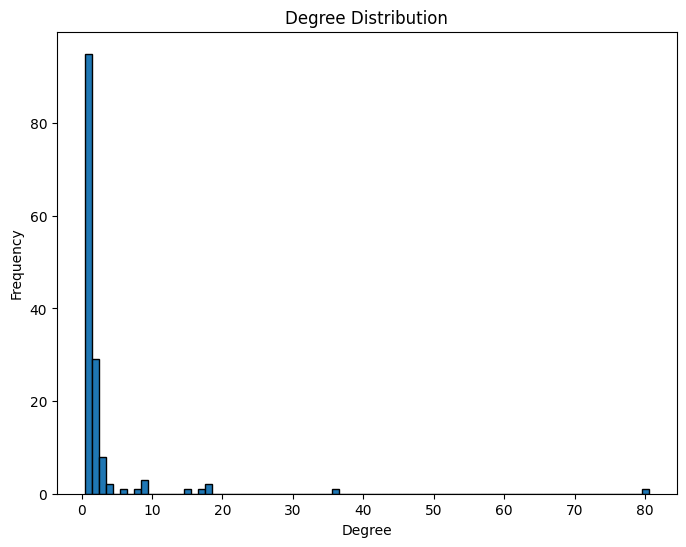

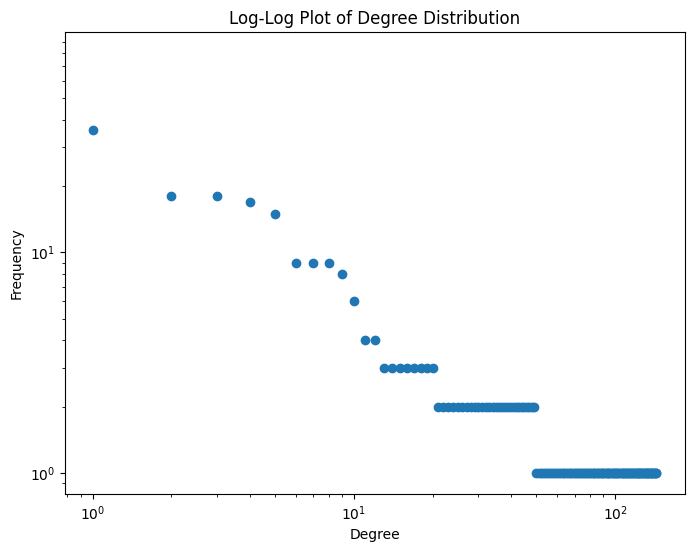

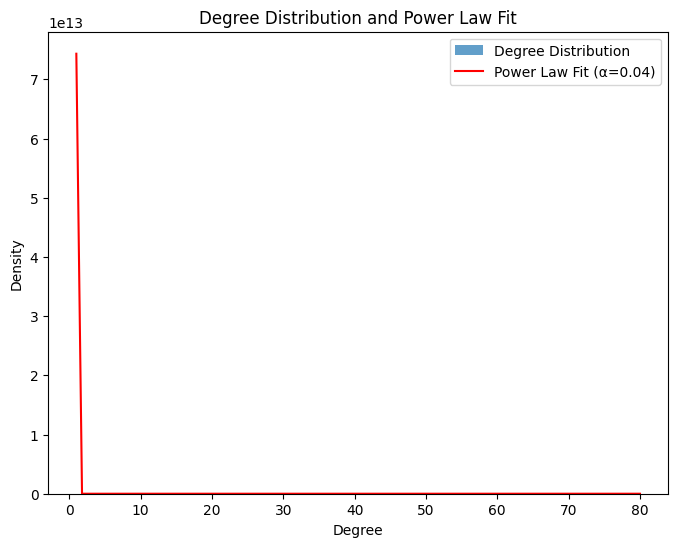

Kolmogorov-Smirnov Test: D = 0.42255776238860854, p-value = 5.3996393610386394e-24


In [127]:
plot_degree_distribution(graph)

In [128]:
visualize_graph_interactive(graph, degree_centrality, title="Final Interactive Graph with Key Hubs Highlighted")